In [1]:
import argparse
import datetime
import random
import scipy
import glob
import time
import h5py
import os

import numpy as np
from pathlib import Path
from math import sqrt,exp,pi
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from sklearn.model_selection import train_test_split

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import mixed_precision
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.layers import LeakyReLU, Dropout, Flatten, Dense, Conv2D, ReLU, BatchNormalization, AveragePooling2D, GlobalAvgPool2D
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.initializers import RandomNormal


import tensorflow_probability as tfp
tfd = tfp.distributions

from DnCNN_skip import DnCNN
from utils import show_coils, reconstruct_from_kspace, reconstruct_magnitude_image, SNR, reconstruct_normalized_image, min_max_norm

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Compute dtype: float16
Variable dtype: float32


In [2]:
# Listing available GPUs

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Setting up mixed precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [4]:
# Data path
data_path = '/multicoil_val/'
VAL_SPLIT = 0.20
TEST_SPLIT = 0.40

# Setting options for the tf.data.Dataset
options = tf.data.Options()
options.experimental_optimization.noop_elimination = True # eliminate no-op transformations
options.experimental_optimization.apply_default_optimizations = False # do not apply default graph optimizations
options.experimental_optimization.autotune_buffers=True 
options.experimental_optimization.map_fusion=True # fuse map transformations
options.experimental_optimization.parallel_batch = True # parallelize copying of batch elements

# Preprocessing options
COIL_HEIGHT = 220
COIL_WIDTH = 114
AUGMENTATION = True

# Datasets dimension for subsampling
SUB_SAMPLE = True
TRAIN_SIZE = 350
VAL_SIZE = 80
TEST_SIZE = 80

# Parameters for data selection
SLICE_RATIO = 2/3
NUM_COILS = 8

# Parameters for image corruption
BLIND_MODE = 0 #da 10 a 16 * 1e-6
STD_MIN = 20 #* 10e-3
STD_MAX = 30 #* 10e-3
STD = 1.5 * 10e-3

# Network parameters
OUTPUT_CHANNELS = 16
KERNEL_SIZE = 3
N_FILTERS = 64
HIDDEN_LAYERS = 19

# Training parameters
LOAD_MODEL = 0
BATCH_SIZE = 64
EPOCHS = 800
LR = 5e-3
PATIENCE = 5 # Early stopping

# Loss weights
BETA = 6*1e3
BETA_MAX = 6*1e3
GAMMA = 1

# Logging
EXPERIMENT_NAME = 'gan'

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
TRAIN_LOGS = 'logs/' + EXPERIMENT_NAME + '_' + current_time + '/train'
VAL_LOGS = 'logs/' + EXPERIMENT_NAME + '_' + current_time + '/val'

GEN_WEIGHTS_PATH = 'GAN/weights/generator/'+EXPERIMENT_NAME
DIS_WEIGHTS_PATH = 'GAN/weights/discriminator/'+EXPERIMENT_NAME
GEN_MODEL_PATH = 'GAN/saved_models/generator/'+EXPERIMENT_NAME
DIS_MODEL_PATH = 'GAN/saved_models/discriminator'+EXPERIMENT_NAME

## Dataset loading

In [5]:
train_path = '../2aprile_blind/data_comp_blind_4aprile/train'
val_path = '../2aprile_blind/data_comp_blind_4aprile/val'
test_path = '../2aprile_blind/data_comp_blind_4aprile/test'

train_dataset = tf.data.experimental.load(train_path)
val_dataset = tf.data.experimental.load(val_path)
test_dataset = tf.data.experimental.load(test_path)

2022-04-27 18:54:54.284661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30967 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


In [6]:
psnrs = tf.keras.metrics.Mean()
for t, s, sn in test_dataset:
    normalized_target_rec = min_max_norm(tf.expand_dims(t, axis=-1))
    normalized_noised_rec = reconstruct_normalized_image(sn)

    noised_psnr = tf.image.psnr(normalized_noised_rec, normalized_target_rec, 1)
    psnrs(noised_psnr)
    
print(psnrs.result())

2022-04-27 18:54:54.649224: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


tf.Tensor(20.445282, shape=(), dtype=float32)


## Discriminator definition

In [7]:
class ConvBlock(tf.keras.Model):
    def __init__(self, n_filters, strides=(2,2)):
        super(ConvBlock, self).__init__()
        
        self.conv = Conv2D(n_filters, KERNEL_SIZE, padding='same', strides=strides)
        self.lrelu = LeakyReLU(alpha=0.2)
        
    def call(self, x):
        out = self.conv(x)
        out = self.lrelu(out)
        
        return out

class Discriminator(tf.keras.Model):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = ConvBlock(N_FILTERS)
        self.conv2 = ConvBlock(N_FILTERS*2)
        self.conv3 = ConvBlock(N_FILTERS*4)

        self.flatten = Flatten()
        self.dropout = Dropout(0.4)
        self.dense = Dense(64)
        self.out_dense = Dense(1)
        self.lrelu = LeakyReLU(alpha=0.2)
        
    def call(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        
        out = self.flatten(out)
        out = self.dropout(out)
        out = self.dense(out)
        out = self.lrelu(out)
        out = self.out_dense(out)
        
        return out

## Training pipeline definition

In [8]:
class Trainer:
    def __init__(self):
        #self.gen_optimizer = Adam(learning_rate=LR)
        self.gen_optimizer = RMSprop(learning_rate=LR)
        self.gen_optimizer = mixed_precision.LossScaleOptimizer(self.gen_optimizer)
        
        #self.dis_optimizer = Adam(learning_rate=0.00005)
        self.dis_optimizer = RMSprop(learning_rate=0.00005)
        self.dis_optimizer = mixed_precision.LossScaleOptimizer(self.dis_optimizer)
        
        self.mse = MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
        self.accuracy = tf.keras.metrics.Accuracy()
        
        self.initialize_metrics()
        
        with tf.device('/gpu:0'):
            if LOAD_MODEL:
                print('Loading pretrained model')
                self.generator = tf.keras.models.load_model(GENERATOR_PATH+'/'+str(epoch))
                self.discriminator = tf.keras.models.load_model(DISCRIMINATOR_PATH+'/'+str(epoch))
            else:
                self.generator = DnCNN(n_filters=N_FILTERS, n_output_channels=OUTPUT_CHANNELS, kernel_size=KERNEL_SIZE, hidden_layers=HIDDEN_LAYERS, internal_res=True)
                self.generator.build(input_shape=[BATCH_SIZE,COIL_HEIGHT,COIL_WIDTH,NUM_COILS*2])
                
                self.discriminator = Discriminator()
                self.discriminator.build(input_shape=[BATCH_SIZE,COIL_HEIGHT,COIL_WIDTH,1*2])
        
        
    def initialize_summary_writers(self):
        train_summary_writer = tf.summary.create_file_writer(TRAIN_LOGS)
        val_summary_writer = tf.summary.create_file_writer(VAL_LOGS)
        
        return train_summary_writer, val_summary_writer
    
    def initialize_metrics(self):
        # these objects keep track of losses and metrics
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.train_psnr = tf.keras.metrics.Mean(name='train_psnr')
        self.train_ssim = tf.keras.metrics.Mean(name='train_ssim')
        
        self.train_dis_loss = tf.keras.metrics.Mean(name='train_disc_loss')
        self.train_dis_acc_real = tf.keras.metrics.Mean(name='train_disc_acc_real')
        self.train_dis_acc_fake = tf.keras.metrics.Mean(name='train_disc_acc_fake')

        self.val_loss = tf.keras.metrics.Mean(name='val_loss')
        self.val_psnr = tf.keras.metrics.Mean(name='val_psnr')
        self.val_ssim = tf.keras.metrics.Mean(name='val_ssim')
        
        self.val_dis_loss = tf.keras.metrics.Mean(name='val_disc_loss')
        self.val_dis_acc_real = tf.keras.metrics.Mean(name='val_disc_acc_real')
        self.val_dis_acc_fake = tf.keras.metrics.Mean(name='val_disc_acc_fake')
        
    def reset_metrics(self):
        self.train_loss.reset_states()
        self.train_psnr.reset_states()
        self.train_ssim.reset_states()
        
        self.train_dis_loss.reset_states()
        self.train_dis_acc_real.reset_states()
        self.train_dis_acc_fake.reset_states()
        
        self.val_loss.reset_states()
        self.val_psnr.reset_states()
        self.val_ssim.reset_states()
        
        self.val_dis_loss.reset_states()
        self.val_dis_acc_real.reset_states()
        self.val_dis_acc_fake.reset_states()
        
    def generator_loss(self, corrupted_rec, target_rec, target_slice, pred_slice, pred_rec, beta, gamma):
        rec_loss = self.mse(target_rec, pred_rec)
        slice_loss = self.mse(target_slice, pred_slice)
                    
        pred_concat = tf.keras.layers.concatenate([tf.expand_dims(pred_rec, axis=-1), tf.expand_dims(corrupted_rec, axis=-1)])

        dis_pred = self.discriminator(pred_concat, training=False)
        dis_loss = self.bce(tf.ones_like(dis_pred), dis_pred)
        dis_loss = tf.cast(dis_loss, tf.float32)
        
        
        return slice_loss + beta * rec_loss + gamma * dis_loss
    
    def discriminator_loss(self, real_output, fake_output):
        target_loss = self.bce(tf.ones_like(real_output), real_output)
        fake_loss = self.bce(tf.zeros_like(fake_output), fake_output)
        
        return target_loss + fake_loss
    
    def train_wrapper(self):
        @tf.function
        def train_step(target_rec, target_slice, corrupted_slice, beta, step, gen_per_step=1, dis_per_step=6, gamma=1e-3):

            with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
                pred_slice = self.generator(corrupted_slice, training=True)

                pred_rec = reconstruct_magnitude_image(pred_slice, True, True)

                corrupted_rec = reconstruct_magnitude_image(corrupted_slice, True, True)

                target_concat = tf.keras.layers.concatenate([tf.expand_dims(target_rec, axis=-1), tf.expand_dims(corrupted_rec, axis=-1)])
                pred_concat = tf.keras.layers.concatenate([tf.expand_dims(pred_rec, axis=-1), tf.expand_dims(corrupted_rec, axis=-1)])

                real_output = self.discriminator(target_concat, training=True)
                fake_output = self.discriminator(pred_concat, training=True)

                dis_loss = self.discriminator_loss(real_output, fake_output)
                dis_scaled_loss = self.dis_optimizer.get_scaled_loss(dis_loss)

                gen_loss = self.generator_loss(corrupted_rec, target_rec, target_slice, pred_slice, pred_rec, beta, gamma)
                gen_scaled_loss = self.gen_optimizer.get_scaled_loss(gen_loss)

                psnr = tf.image.psnr(pred_rec, target_rec, 1)    
                ssim = tf.image.ssim(pred_rec, target_rec, 1)


            gen_scaled_gradients = gen_tape.gradient(gen_scaled_loss, self.generator.trainable_variables)
            gen_gradients = self.gen_optimizer.get_unscaled_gradients(gen_scaled_gradients)

            dis_scaled_gradients = dis_tape.gradient(dis_scaled_loss, self.discriminator.trainable_variables)
            dis_gradients = self.dis_optimizer.get_unscaled_gradients(dis_scaled_gradients)

            if step % gen_per_step == 0:
                self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

            elif step % dis_per_step == 0:
                self.dis_optimizer.apply_gradients(zip(dis_gradients, self.discriminator.trainable_variables))

            self.train_dis_loss(dis_loss)
            self.train_loss(gen_loss)
            self.train_psnr(psnr)
            self.train_ssim(ssim)

            # We apply the sigmoid so that we have a value between 0 and 1
            fake_out = tf.math.sigmoid(tf.squeeze(fake_output, axis=-1))
            real_out = tf.math.sigmoid(tf.squeeze(real_output, axis=-1))

            # We round to the closest integer, so that we have either 0 or 1
            fake_out = tf.math.round(fake_out)
            real_out = tf.math.round(real_out)

            acc_fake = self.accuracy(tf.zeros_like(fake_output), fake_out)
            self.train_dis_acc_fake(acc_fake)

            acc_real = self.accuracy(tf.ones_like(real_output), real_out)
            self.train_dis_acc_real(acc_real)

            #return fake_output, dis_output, preds
                
        return train_step
                


    def val_wrapper(self):
        
        @tf.function
        def val_step(target_rec, target_slice, corrupted_slice, beta, gamma=1e-3):
            pred_slice = self.generator(corrupted_slice, training=False)

            pred_rec = reconstruct_magnitude_image(pred_slice, True, True)

            corrupted_rec = reconstruct_magnitude_image(corrupted_slice, True, True)
            
            target_concat = tf.keras.layers.concatenate([tf.expand_dims(target_rec, axis=-1), tf.expand_dims(corrupted_rec, axis=-1)])
            pred_concat = tf.keras.layers.concatenate([tf.expand_dims(pred_rec, axis=-1), tf.expand_dims(corrupted_rec, axis=-1)])

            real_output = self.discriminator(target_concat, training=False)
            fake_output = self.discriminator(pred_concat, training=False)

            dis_loss = self.discriminator_loss(real_output, fake_output)

            gen_loss = self.generator_loss(corrupted_rec, target_rec, target_slice, pred_slice, pred_rec, beta, gamma)

            psnr = tf.image.psnr(pred_rec, target_rec, 1)    
            ssim = tf.image.ssim(pred_rec, target_rec, 1)

            self.val_loss(gen_loss)
            self.val_psnr(psnr)
            self.val_ssim(ssim)
            self.val_dis_loss(dis_loss)

            # We apply the sigmoid so that we have a value between 0 and 1
            fake_out = tf.math.sigmoid(tf.squeeze(fake_output, axis=-1))
            real_out = tf.math.sigmoid(tf.squeeze(real_output, axis=-1))

            # We round to the closest integer, so that we have either 0 or 1
            fake_out = tf.math.round(fake_out)
            real_out = tf.math.round(real_out)

            acc_fake = self.accuracy(tf.zeros_like(fake_output), fake_out)
            self.val_dis_acc_fake(acc_fake)

            acc_real = self.accuracy(tf.ones_like(real_output), real_out)
            self.val_dis_acc_real(acc_real)
                            
        return val_step
    
    def train(self):        
        train_summary_writer, val_summary_writer = self.initialize_summary_writers()
        
        train_step_count = 0
        
        # Early stopping
        es_check = 0
        es_check_min = 0
        es_min = 50000
        es_prev = 50000
        old_lr = LR
        times = 0
        
        
        beta = BETA
        gamma = GAMMA
        #beta_step = BETA_MAX / 150 # The beta parameter linearly increases between epochs 50 and 200
        
        _,_,val_corr = next(iter(val_dataset))
        
        AUTOTUNE = tf.data.AUTOTUNE

        for epoch in range(EPOCHS):
            #if epoch >= 50 and epoch < 200:
                #beta += beta_step
            
            #if epoch == 300:
            #    self.gen_optimizer.lr.assign(3e-4)
                
            train_dataset.prefetch(buffer_size=AUTOTUNE)
            val_dataset.prefetch(buffer_size=AUTOTUNE)

            t = time.time()

            print(f'EPOCH: {epoch}')
            
            # Reset the metrics at the start of the next epoch
            self.reset_metrics()

            # Training loop
            train_step = self.train_wrapper()

            for target_rec, target_slice, corrupted_slice in train_dataset:
                with tf.device('/gpu:0'):
                    train_step(target_rec, target_slice, corrupted_slice, beta, epoch, gamma=gamma)
                    #fake_output, output, preds = train_step(target_rec, target_slice, corrupted_slice, 2, beta, epoch, gamma=gamma)
                    #print(fake_output.shape)
                    #print(fake_output)
                    #print(output.shape)
                    #print(output)
                    #print(preds.shape)
                    #print(preds)
                    

            val_step = self.val_wrapper()
            
            # Validation loop
            for target_rec, target_slice, corrupted_slice in val_dataset:
                with tf.device('/gpu:0'):
                    val_step(target_rec, target_slice, corrupted_slice, beta)

            # Logging losses and metrics
            with train_summary_writer.as_default():
                tf.summary.scalar('Loss', self.train_loss.result(), step=epoch)
                tf.summary.scalar('PSNR', self.train_psnr.result(), step=epoch)
                tf.summary.scalar('SSIM', self.train_ssim.result(), step=epoch)
                tf.summary.scalar('BETA', beta, step=epoch)
                tf.summary.scalar('Discriminator loss', self.train_dis_loss.result(), step=epoch)
                tf.summary.scalar('Discriminator accuracy real', self.train_dis_acc_real.result(), step=epoch)
                tf.summary.scalar('Discriminator accuracy fake', self.train_dis_acc_fake.result(), step=epoch)

            with val_summary_writer.as_default():    
                tf.summary.scalar('Loss', self.val_loss.result(), step=epoch)
                tf.summary.scalar('PSNR', self.val_psnr.result(), step=epoch)
                tf.summary.scalar('SSIM', self.val_ssim.result(), step=epoch)
                tf.summary.scalar('Discriminator loss', self.val_dis_loss.result(), step=epoch)
                tf.summary.scalar('Discriminator accuracy real', self.val_dis_acc_real.result(), step=epoch)
                tf.summary.scalar('Discriminator accuracy fake', self.val_dis_acc_fake.result(), step=epoch)

            
            if epoch % 25 == 0:
                print('Model checkpointed at epoch:',epoch)
                self.generator.save_weights(GEN_WEIGHTS_PATH)
                self.discriminator.save_weights(DIS_WEIGHTS_PATH)
                
                self.generator.save(GEN_MODEL_PATH+'/'+str(epoch))
                self.discriminator.save(DIS_MODEL_PATH+'/'+str(epoch))

            elapsed = (time.time() - t)/60

            print("TRAIN -> Loss = {:.5f}, PSNR = {:.5f}, SSIM = {:.5f}".format(self.train_loss.result(),self.train_psnr.result(),self.train_ssim.result()))
            print("VALIDATION -> Loss = {:.5f}, PSNR = {:.5f}, SSIM = {:.5f}".format(self.val_loss.result(),self.val_psnr.result(),self.val_ssim.result()))
            print("DISCRIMINATOR TRAINING -> Loss = {:.5f}, Accuracy real = {:.5f}, , Accuracy fake = {:.5f}".format(self.train_dis_loss.result(), self.train_dis_acc_real.result(), self.train_dis_acc_fake.result()))
            print("DISCRIMINATOR VALIDATION -> Loss = {:.5f}, Accuracy real = {:.5f}, Accuracy fake = {:.5f}".format(self.val_dis_loss.result(), self.val_dis_acc_real.result(), self.val_dis_acc_fake.result()))
            print("Last epoch lasted: {:.2f} min\n".format(elapsed))
            
            if self.val_loss.result() < es_min:
                es_min = self.val_loss.result()
                es_prev = es_min
                es_check = 0
                es_check_min = 0
            elif self.val_loss.result() < es_prev:
                es_prev = self.val_loss.result()
                es_check = 0
                es_check_min += 1
            else:
                es_prev = self.val_loss.result()
                es_check += 1
                es_check_min += 1

            if es_check == PATIENCE or es_check_min == 20:
                if times < 8:
                    new_lr = old_lr * 0.5
                    self.gen_optimizer.lr.assign(new_lr)
                    old_lr = new_lr
                    times += 1
                    print(f'\nReached minimum validation loss, {es_min}, {es_check_min} epochs ago.')
                    print(f'Validation loss did not decrease over the last {es_check} epochs.')
                    print(f'Learning rate now is: {new_lr}\n\n')
                else:
                    print(f'\nReached minimum validation loss, {es_min}, {es_check_min} epochs ago.')
                    print(f'Validation loss did not decrease over the last {es_check} epochs.')
                    print(f'EARLY STOPPING\n\n')
                    break

In [9]:
trainer = Trainer()
trainer.train()

EPOCH: 0


2022-04-27 18:55:58.372488: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8300


Model checkpointed at epoch: 0


2022-04-27 18:58:04.626652: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


TRAIN -> Loss = 5.59051, PSNR = 35.30621, SSIM = 0.65431
VALIDATION -> Loss = 45.66579, PSNR = 22.30557, SSIM = 0.60444
DISCRIMINATOR TRAINING -> Loss = 1.38669, Accuracy real = 0.55689, , Accuracy fake = 0.54795
DISCRIMINATOR VALIDATION -> Loss = 1.38489, Accuracy real = 0.57811, Accuracy fake = 0.57608
Last epoch lasted: 3.17 min

EPOCH: 1
TRAIN -> Loss = 2.15663, PSNR = 38.46407, SSIM = 0.79392
VALIDATION -> Loss = 120.75665, PSNR = 18.01478, SSIM = 0.59970
DISCRIMINATOR TRAINING -> Loss = 1.38672, Accuracy real = 0.57903, , Accuracy fake = 0.57813
DISCRIMINATOR VALIDATION -> Loss = 1.38477, Accuracy real = 0.58127, Accuracy fake = 0.58033
Last epoch lasted: 1.79 min

EPOCH: 2
TRAIN -> Loss = 1.79615, PSNR = 39.84924, SSIM = 0.86692
VALIDATION -> Loss = 14.32362, PSNR = 27.42934, SSIM = 0.62285
DISCRIMINATOR TRAINING -> Loss = 1.38667, Accuracy real = 0.58169, , Accuracy fake = 0.58114
DISCRIMINATOR VALIDATION -> Loss = 1.38489, Accuracy real = 0.58114, Accuracy fake = 0.58052
Last 

In [10]:
trainer.generator.save_weights('./trained_models/GAN_correct/rmsProp_blind/weights/generator')
trainer.discriminator.save_weights('./trained_models/GAN_correct/rmsProp_blind/weights/discriminator')

trainer.generator.save('./trained_models/GAN_correct/rmsProp_blind/models/generator')
trainer.discriminator.save('./trained_models/GAN_correct/rmsProp_blind/models/discriminator')

In [11]:
generator = trainer.generator
discriminator = trainer.discriminator

In [ ]:
generator = DnCNN(n_filters=N_FILTERS, n_output_channels=OUTPUT_CHANNELS, kernel_size=KERNEL_SIZE, hidden_layers=HIDDEN_LAYERS)
generator.build(input_shape=[BATCH_SIZE,COIL_HEIGHT,COIL_WIDTH,NUM_COILS*2])
generator.load_weights('./trained_models/GAN_correct/rmsProp_blind/weights/generator')

discriminator = Discriminator()
discriminator.build(input_shape=[BATCH_SIZE,COIL_HEIGHT,COIL_WIDTH,1*2])
discriminator.load_weights('./trained_models/GAN_correct/rmsProp_blind/weights/discriminator')

In [12]:
generator.summary()

Model: "dn_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  9280      
_________________________________________________________________
conv_block (ConvBlock)       multiple                  37184     
_________________________________________________________________
conv_block_1 (ConvBlock)     multiple                  37184     
_________________________________________________________________
conv_block_2 (ConvBlock)     multiple                  37184     
_________________________________________________________________
conv_block_3 (ConvBlock)     multiple                  37184     
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  37184     
_________________________________________________________________
conv_block_5 (ConvBlock)     multiple                  37184

In [13]:
mse = MeanSquaredError()
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def generator_loss(target_rec, target_slice, pred_slice):
    rec_loss = mse(target_rec, reconstruct_magnitude_image(pred_slice, True, True))
    slice_loss = mse(target_slice, pred_slice)

    return slice_loss + BETA * rec_loss

@tf.function
def discriminator_loss(real_output, fake_output):
    target_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)

    return target_loss + fake_loss

In [14]:
def predict(test_dataset):
    loss_noisy = tf.keras.metrics.Mean(name='loss_noisy')
    psnr_noisy = tf.keras.metrics.Mean(name='psnr_noisy')
    ssim_noisy = tf.keras.metrics.Mean(name='ssim_noisy')
    
    loss_denoised = tf.keras.metrics.Mean(name='loss_denoised')
    psnr_denoised = tf.keras.metrics.Mean(name='psnr_denoised')
    ssim_denoised = tf.keras.metrics.Mean(name='ssim_denoised')
    
    loss_disc = tf.keras.metrics.Mean(name='discriminator_loss')
    
    psnrs = []
    ssims = []
    
    for target_rec, target_slice, corr_slice in test_dataset:
        
        pred_slice = generator(corr_slice, training=False)

        pred_rec = reconstruct_magnitude_image(pred_slice, True, True)

        corrupted_rec = reconstruct_magnitude_image(corr_slice, True, True)
            
        target_concat = tf.keras.layers.concatenate([tf.expand_dims(target_rec, axis=-1), tf.expand_dims(corrupted_rec, axis=-1)])
        pred_concat = tf.keras.layers.concatenate([tf.expand_dims(pred_rec, axis=-1), tf.expand_dims(corrupted_rec, axis=-1)])

        real_output = discriminator(target_concat, training=False)
        fake_output = discriminator(pred_concat, training=False)

        corr_loss = generator_loss(target_rec, target_slice, corr_slice)
        pred_loss = generator_loss(target_rec, target_slice, pred_slice)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        loss_noisy(corr_loss)
        loss_denoised(pred_loss)
        loss_disc(disc_loss)

        normalized_pred_rec = reconstruct_normalized_image(pred_slice)
        normalized_target_rec = min_max_norm(tf.expand_dims(target_rec, axis=-1))
        normalized_noised_rec = reconstruct_normalized_image(corr_slice)

        pred_psnr = tf.image.psnr(normalized_pred_rec, normalized_target_rec, 1)
        noised_psnr = tf.image.psnr(normalized_noised_rec, normalized_target_rec, 1)

        pred_ssim = tf.image.ssim(normalized_pred_rec, normalized_target_rec, 1)
        noised_ssim = tf.image.ssim(normalized_noised_rec, normalized_target_rec, 1)

        psnr_noisy(noised_psnr)
        psnr_denoised(pred_psnr)
        
        ssim_noisy(noised_ssim)
        ssim_denoised(pred_ssim)

        psnrs.append(pred_psnr.numpy())
        ssims.append(pred_ssim.numpy())
    
    print("METRICS FOR THE NOISY IMAGES: GEN_LOSS = {:.5f}, PSNR = {:.5f}, SSIM = {:.5f}".format(loss_noisy.result(), psnr_noisy.result(), ssim_noisy.result()))
    print("METRICS FOR THE DENOISED IMAGES: GEN_LOSS = {:.5f}, PSNR = {:.5f}, SSIM = {:.5f}".format(loss_denoised.result(), psnr_denoised.result(), ssim_denoised.result()))
    print("DISCRIMINATOR LOSS = {:.5f}".format(loss_disc.result()))
    
    print(f'Denoised images PSNR: Mean = {sum(psnrs)/len(psnrs)}, Max = {max(psnrs)}, Min = {min(psnrs)}')
    print(f'Denoised images SSIM: Mean = {sum(ssims)/len(ssims)}, Max = {max(ssims)}, Min = {min(ssims)}')

In [15]:
predict(test_dataset)

METRICS FOR THE NOISY IMAGES: GEN_LOSS = 2.43434, PSNR = 20.44528, SSIM = 0.32723
METRICS FOR THE DENOISED IMAGES: GEN_LOSS = 0.20119, PSNR = 32.92150, SSIM = 0.85713
DISCRIMINATOR LOSS = 1.38671
Denoised images PSNR: Mean = [32.921505], Max = [40.39001], Min = [24.30347]
Denoised images SSIM: Mean = [0.8571336], Max = [0.9630899], Min = [0.35233194]


In [16]:
def show_examples(test_dataset):
    test_dataset = list(test_dataset)
    test_size = len(test_dataset)
    idxs = [random.randint(0, test_size-1) for i in range(10)]
    idxs.sort()
    
    fig, axs = plt.subplots(10, 3, figsize=[15,100])
    
    for i in range(test_size):
        if len(idxs) == 0:
            break
        if i != idxs[0]:
            continue
        
        target_rec, target_slice, corr_slice = test_dataset[i]
        
        pred_slice = generator(corr_slice, training=False)

        normalized_pred_rec = reconstruct_normalized_image(pred_slice)
        normalized_target_rec = min_max_norm(tf.expand_dims(target_rec, axis=-1))
        normalized_noised_rec = reconstruct_normalized_image(corr_slice)
    
        n = len(idxs) - 10

        
        axs[n][0].imshow(normalized_noised_rec[0,:,:,:], cmap='gray', vmin = 0, vmax = 1)
        axs[n][0].axis('off')
        axs[n][0].set_title('Noisy')

        axs[n][1].imshow(normalized_pred_rec[0,:,:,:], cmap='gray', vmin = 0, vmax = 1)
        axs[n][1].axis('off')
        axs[n][1].set_title('Prediction')

        axs[n][2].imshow(normalized_target_rec[0,:,:,:], cmap='gray', vmin = 0, vmax = 1)
        axs[n][2].axis('off')
        axs[n][2].set_title('Target reconstruction')
        
        idxs = idxs[1:]

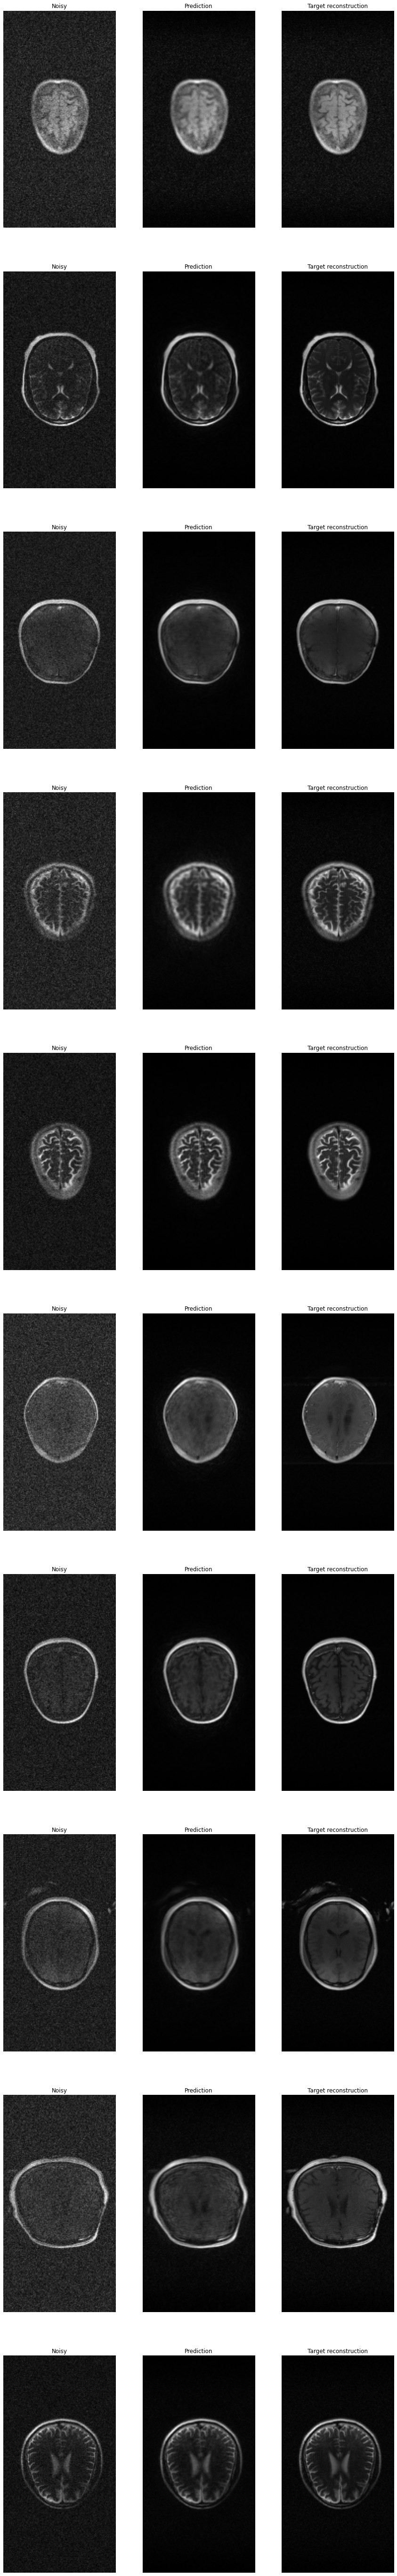

In [17]:
show_examples(test_dataset)

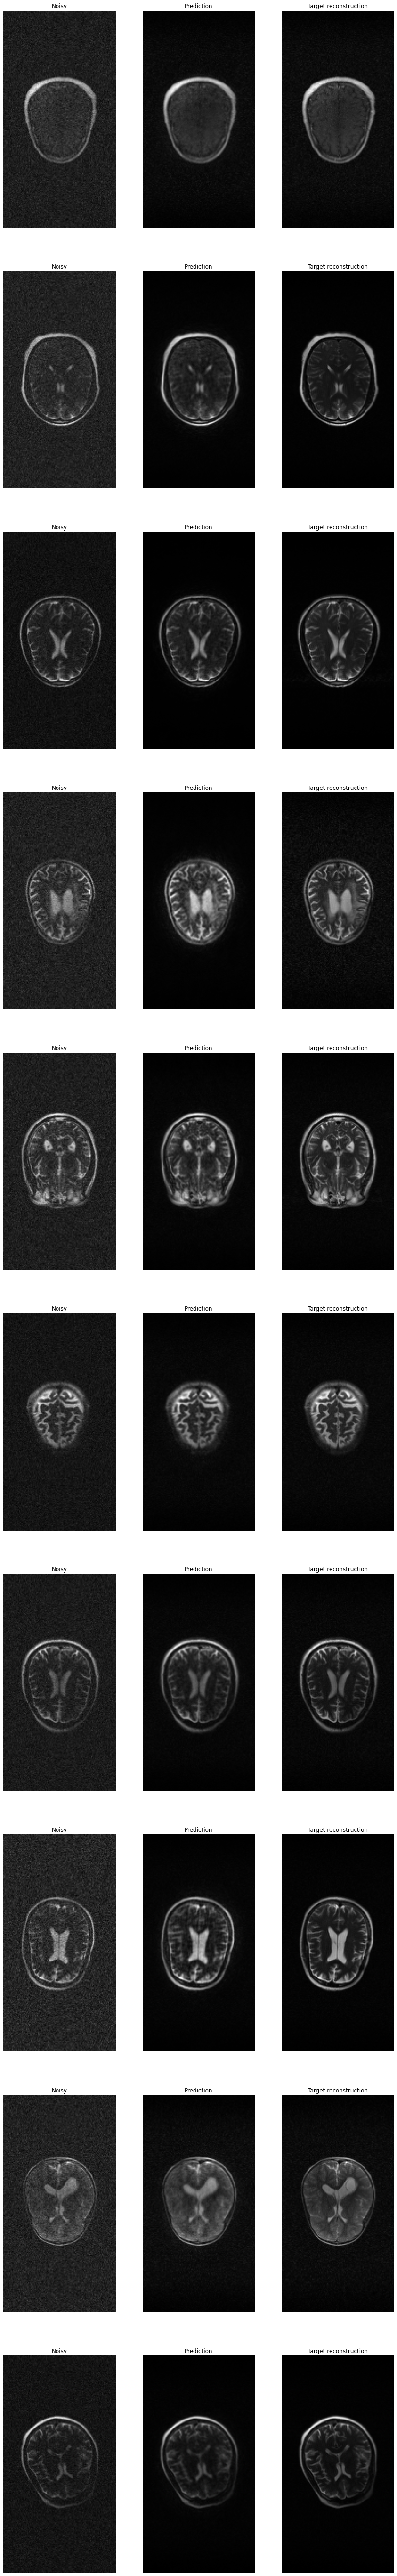

In [18]:
show_examples(test_dataset)